In [1]:
from platform import python_version
python_version()

'3.6.12'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import time
from sklearn.metrics import roc_auc_score, log_loss

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.__version__

'1.15.0'

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13882896413962472989
]


In [8]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0']


## Functions 

In [9]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

In [10]:
#List of metric for classiffication models 

def metrics_classific(y,predicted,X):
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
    confusion_matrix = confusion_matrix(y, predicted)
    print(confusion_matrix)
    print(classification_report(y, predicted))

    # Validation ROC-AUC score
    from sklearn.metrics import roc_auc_score
    valid_score = roc_auc_score(y, predicted)
    print('Validation ROC-AUC score:', valid_score)

    # AUC score
    from sklearn.metrics import  auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, predicted)
    auc = auc(false_positive_rate, true_positive_rate)
    print('Validation AUC score:    ', auc)
    print("Accuracy: %.2f%%" % (accuracy_score(y, predicted) * 100.0))

In [11]:
def sigmoid(z):
    return 1/(1.0 + np.exp(-z))

In [12]:
#transform prob_prediction to predictions 
def predictor(prob_prediction):
    return np.array(([propability[0] < propability[1] for propability in prob_prediction]), dtype=int)

# Import dataset

In [13]:
# can download data from link X_true.csv: 
X_true = pd.read_csv('X_true.csv').values

In [14]:
y_true = pd.read_csv('y_true.csv').values
type(y_true)

numpy.ndarray

In [15]:
X_true.shape, y_true.shape

((10800, 12288), (10800, 1))

## Split data

In [16]:
from sklearn.model_selection import train_test_split
seed = 78
test_size = 0.33
X_train, X_, y_train, y_ = train_test_split(X_true, y_true, test_size=test_size, random_state=seed)
X_test, X_validate, y_test, y_validate = train_test_split(X_, y_, test_size=test_size, random_state=seed)

In [17]:
print('X_train size :', X_train.shape[0],'|X_test size :', X_test.shape[0],'|X_validate size :', X_validate.shape[0])

X_train size : 7236 |X_test size : 2387 |X_validate size : 1177


In [18]:
%%time 
# Benchmark
from sklearn.linear_model import Perceptron
Per = Perceptron(random_state=seed).fit(X_train, y_train)
predictions = Per.predict(X_test)
metrics_classific(y_test,predictions, X_test)

[[939 129]
 [503 816]]
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75      1068
         1.0       0.86      0.62      0.72      1319

    accuracy                           0.74      2387
   macro avg       0.76      0.75      0.73      2387
weighted avg       0.77      0.74      0.73      2387

Validation ROC-AUC score: 0.7489319879718206
Validation AUC score:     0.7489319879718206
Accuracy: 73.52%
Wall time: 10.3 s


# Perceptron

## Y_vectors OneHotEncoder preprocessing

In [19]:
y_train

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [20]:
shape = y_train.shape
y_orig = y_train.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_orig) 
data_y = oneHot.transform(y_orig).toarray()

In [21]:
shape = y_test.shape
y_test_orig = y_test.reshape(shape[0],1)

from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder()
oneHot.fit(y_test_orig) 
test_y = oneHot.transform(y_test_orig).toarray() 

In [22]:
data_x = X_train 
data_x.shape, data_y.shape

((7236, 12288), (7236, 2))

In [23]:
data_y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## model parameters

In [31]:
#Input pretrained parameters
W = pd.read_csv('weights.csv',header=None).values
b = pd.read_csv('bias.csv',header=None).values

W = tf.Variable(tf.convert_to_tensor(W, dtype=tf.float32))
b = tf.Variable(tf.convert_to_tensor(np.reshape(b, (2,)), dtype=tf.float32))

In [32]:
learning_rate = 0.03
L2 =0.0001 #regulization
n_epochs = 3000

num_features = data_x.shape[1]
num_classes = data_y.shape[1]

X_hold = tf.placeholder(tf.float32, [None, num_features]) 
Y_hold = tf.placeholder(tf.float32, [None,num_classes])

##random weights
#W = tf.Variable(tf.truncated_normal([num_features, num_classes], stddev=0.1))

##specific weights
#Initial_W = pd.read_csv('Initial_W.csv',header=None).values
#W = tf.Variable(tf.convert_to_tensor(Initial_W, dtype=tf.float32))

b = tf.Variable(tf.constant(0.1, shape=[num_classes]))

Z = tf.matmul(X_hold,W) + b
logit = tf.sigmoid(Z)

## Cost function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_hold, logits=logit)+ L2*tf.nn.l2_loss(W))

#logloss = Y_hold * -tf.log(logit) + (1 - Y_hold) * tf.log(1 - logit)
#loss = tf.reduce_mean(logloss)

#loss = tf.reduce_mean(-tf.reduce_sum(Y_hold * tf.log(logit), reduction_indices=[0]))

#Optimizator
optimizator = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss) #Gradient Descent
#optimizator = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Adam  

train_acc = []
test_acc = []
losses = []
aucs = []
# Define the accuracy
prediction = tf.round(logit)
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, Y_hold), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Initial session

In [34]:
%%time
##Initial session
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    #save initial weights
    Initial_W = sess.run(W)
    
    # Gradient descent
    for i in range(0,n_epochs):
        _, iloss, y_hat, temp_train_acc =  sess.run([optimizator, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y})
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
     
    # Calculate test auc
    prob_predictions = sess.run(Z, feed_dict={X_hold:X_test})
    weights = sess.run(W)
    bias = sess.run(b)
    saver.save(sess, 'example_long')

0 th Epoch Train AUC: 0.6438 Loss: 0.6488
100 th Epoch Train AUC: 0.6462 Loss: 0.6480
200 th Epoch Train AUC: 0.6469 Loss: 0.6471
300 th Epoch Train AUC: 0.6391 Loss: 0.6496
400 th Epoch Train AUC: 0.6477 Loss: 0.6468
500 th Epoch Train AUC: 0.6483 Loss: 0.6464
600 th Epoch Train AUC: 0.6506 Loss: 0.6458
700 th Epoch Train AUC: 0.6458 Loss: 0.6472
800 th Epoch Train AUC: 0.6507 Loss: 0.6465
900 th Epoch Train AUC: 0.6520 Loss: 0.6451
1000 th Epoch Train AUC: 0.6505 Loss: 0.6453
1100 th Epoch Train AUC: 0.6503 Loss: 0.6453
1200 th Epoch Train AUC: 0.6542 Loss: 0.6444
1300 th Epoch Train AUC: 0.6526 Loss: 0.6444
1400 th Epoch Train AUC: 0.6534 Loss: 0.6441
1500 th Epoch Train AUC: 0.6542 Loss: 0.6438
1600 th Epoch Train AUC: 0.6559 Loss: 0.6437
1700 th Epoch Train AUC: 0.6528 Loss: 0.6459
1800 th Epoch Train AUC: 0.6378 Loss: 0.6556
1900 th Epoch Train AUC: 0.6487 Loss: 0.6456
2000 th Epoch Train AUC: 0.6577 Loss: 0.6427
2100 th Epoch Train AUC: 0.6414 Loss: 0.6482
2200 th Epoch Train AU

In [35]:
tensor_predictions = predictor(prob_predictions)
metrics_classific(y_test,tensor_predictions, X_test)

[[ 299  769]
 [  92 1227]]
              precision    recall  f1-score   support

         0.0       0.76      0.28      0.41      1068
         1.0       0.61      0.93      0.74      1319

    accuracy                           0.64      2387
   macro avg       0.69      0.61      0.58      2387
weighted avg       0.68      0.64      0.59      2387

Validation ROC-AUC score: 0.6051063681770039
Validation AUC score:     0.6051063681770039
Accuracy: 63.93%


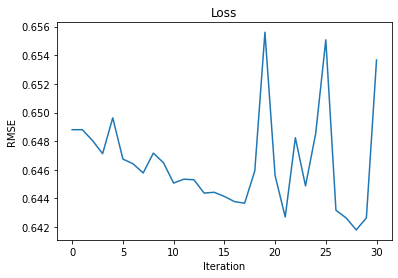

In [45]:
plt.plot(range(3100//100), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE') 

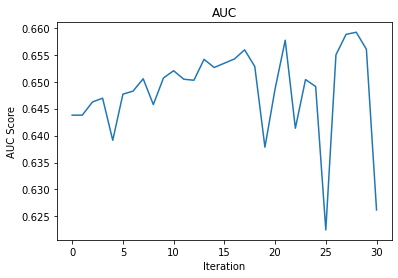

In [47]:
plt.plot(range(3100//100), aucs)
plt.title('AUC')
plt.xlabel('Iteration')
_ = plt.ylabel('AUC Score') 

train accuracy : 0.63571036
test accuracy : 0.64620864


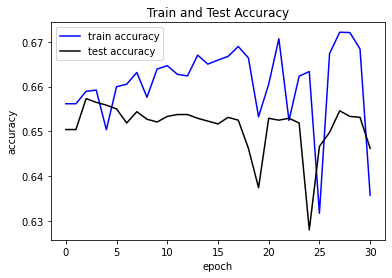

In [48]:
##learning_rate = 0.1
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
print("train accuracy :",train_acc[-1] )
print("test accuracy :",test_acc[-1] )
plt.show()

In [49]:
max(test_acc)

0.6573104

## restored session 1

In [50]:
%%time
##restored session
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('example_long.meta')
    sess.run(tf.global_variables_initializer())
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
     
    # Gradient descent
    for i in range(0,n_epochs):
        _, iloss, y_hat, temp_train_acc =  sess.run([optimizator, loss, prediction, accuracy], {X_hold:data_x, Y_hold:data_y})
        temp_test_acc = sess.run(accuracy, feed_dict={X_hold:X_test, Y_hold:test_y})
        if i%100==0:
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            losses.append(iloss)
            aucs.append(roc_auc_score(data_y, y_hat))
        if i%100==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, roc_auc_score(data_y, y_hat), iloss))
    
    
    # Calculate test auc
    prob_predictions = sess.run(Z, feed_dict={X_hold:X_test})
    
    weights = sess.run(W)
    bias = sess.run(b)
    #new_saver.save(sess, 'example2')   

INFO:tensorflow:Restoring parameters from ./example_long
0 th Epoch Train AUC: 0.6192 Loss: 0.6561
100 th Epoch Train AUC: 0.6595 Loss: 0.6414
200 th Epoch Train AUC: 0.6615 Loss: 0.6408
300 th Epoch Train AUC: 0.6547 Loss: 0.6431
400 th Epoch Train AUC: 0.6445 Loss: 0.6521
500 th Epoch Train AUC: 0.6630 Loss: 0.6402
600 th Epoch Train AUC: 0.6635 Loss: 0.6402
700 th Epoch Train AUC: 0.6189 Loss: 0.6562
800 th Epoch Train AUC: 0.6624 Loss: 0.6401
900 th Epoch Train AUC: 0.6636 Loss: 0.6398
1000 th Epoch Train AUC: 0.6644 Loss: 0.6396
1100 th Epoch Train AUC: 0.6627 Loss: 0.6400
1200 th Epoch Train AUC: 0.6557 Loss: 0.6425
1300 th Epoch Train AUC: 0.6164 Loss: 0.6571
1400 th Epoch Train AUC: 0.6651 Loss: 0.6391
1500 th Epoch Train AUC: 0.6654 Loss: 0.6392
1600 th Epoch Train AUC: 0.6637 Loss: 0.6406
1700 th Epoch Train AUC: 0.6615 Loss: 0.6404
1800 th Epoch Train AUC: 0.6455 Loss: 0.6516
1900 th Epoch Train AUC: 0.6611 Loss: 0.6405
2000 th Epoch Train AUC: 0.6650 Loss: 0.6391
2100 th Ep

In [51]:
tensor_predictions = predictor(prob_predictions)
metrics_classific(y_test,tensor_predictions, X_test)

[[ 174  894]
 [  53 1266]]
              precision    recall  f1-score   support

         0.0       0.77      0.16      0.27      1068
         1.0       0.59      0.96      0.73      1319

    accuracy                           0.60      2387
   macro avg       0.68      0.56      0.50      2387
weighted avg       0.67      0.60      0.52      2387

Validation ROC-AUC score: 0.5613696961436567
Validation AUC score:     0.5613696961436567
Accuracy: 60.33%


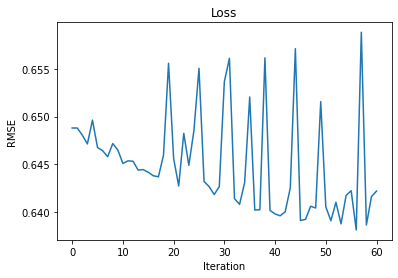

In [52]:
plt.plot(range(len(losses)), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE') 

train accuracy : 0.66763407
test accuracy : 0.6550063


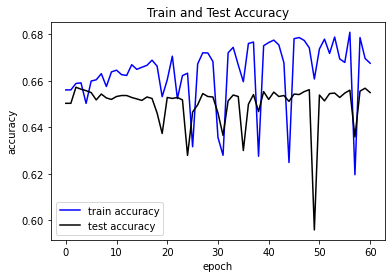

In [53]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
print("train accuracy :",train_acc[-1] )
print("test accuracy :",test_acc[-1] )
plt.show()

## Save model

In [54]:
#Save model
from numpy import loadtxt
np.savetxt('Initial_W.csv', Initial_W, delimiter=',')
np.savetxt('weights.csv', weights, delimiter=',')
np.savetxt('bias.csv', bias, delimiter=',')

# Model validation

In [55]:
#Load model
weights = pd.read_csv('weights.csv',header=None).values
bias = pd.read_csv('bias.csv',header=None).values

In [56]:
weights.shape

(12288, 2)

In [57]:
#check test matrics
val_predict = np.dot(np.array(X_test),weights)
new_val_predict = np.zeros(shape=(val_predict.shape))
for i in range(len(val_predict)):
    new_val_predict[i] = [val_predict[i][0]+bias[0], val_predict[i][1]+bias[1]]
valudate_predictions = predictor(val_predict)
metrics_classific(y_test,valudate_predictions, X_test)  
print("LogLoss :", log_loss(y_test,sigmoid(val_predict)))

[[ 174  894]
 [  53 1266]]
              precision    recall  f1-score   support

         0.0       0.77      0.16      0.27      1068
         1.0       0.59      0.96      0.73      1319

    accuracy                           0.60      2387
   macro avg       0.68      0.56      0.50      2387
weighted avg       0.67      0.60      0.52      2387

Validation ROC-AUC score: 0.5613696961436567
Validation AUC score:     0.5613696961436567
Accuracy: 60.33%
LogLoss : 2.444705514458254


In [58]:
#Model validation
val_predict = np.dot(np.array(X_validate),weights)
new_val_predict = np.zeros(shape=(val_predict.shape))
for i in range(len(val_predict)):
    new_val_predict[i] = [val_predict[i][0]+bias[0], val_predict[i][1]+bias[1]]

valudate_predictions = predictor(new_val_predict)
metrics_classific(y_validate,valudate_predictions, X_validate)
print("LogLoss :", log_loss(y_validate,sigmoid(val_predict)))

[[108 427]
 [ 28 614]]
              precision    recall  f1-score   support

         0.0       0.79      0.20      0.32       535
         1.0       0.59      0.96      0.73       642

    accuracy                           0.61      1177
   macro avg       0.69      0.58      0.53      1177
weighted avg       0.68      0.61      0.54      1177

Validation ROC-AUC score: 0.5791277258566978
Validation AUC score:     0.5791277258566978
Accuracy: 61.34%
LogLoss : 1.907405656328022
